# Tutorial -  Planar Earth-Mars Transfer and Rendez-Vous
#### Thomas Goldman 

In this tutorial, I will explain how the DOLPHINN package works internally and how you can use it to solve your own problems. Realise that currently DOLPHINN is quite tailored to spacecraft trajectories and doens't nicely generalize to other optimal control problems. The example problem considered here, will be the optimal control problem of sending a spacecraft to meet with Mars and match its velocity by using electric propulsion. First, lets introduce the problem. 

Consider a spacecraft with initial mass $m$ and an engine that can produce a maximum thrust force $u_{max}$ with a specific impulse $I_{sp}$. The acceleration model consists of only the central gravitional attraction from the sun. The state of the spacecraft will be described in terms of polar coordinates, $r, \theta$ and the velocity vector will be described in terms of the transverse component $v_{\theta}$ and the radial component $v_r$, as per the figure. The control vector of the thrust produced by the electric propulsion engine is described in the same basis as the velocity. However, the control is parameterized in terms of the magnitude $u_t = |\mathbf{u}|$ and an angle $u_{\phi}$. 

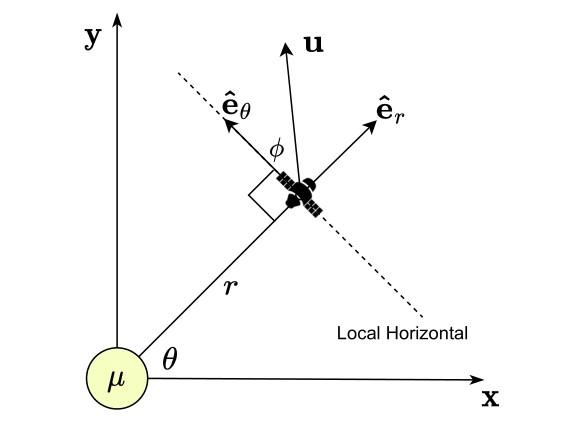

- The state of the spacecraft is then 


$$\mathbf{z} = \begin{bmatrix} r \\ \theta \\ v_r \\ v_{\theta} \end{bmatrix} $$

- The equations of motion are then

$$  \begin{align} \dot{r} &= v_r\\
    \dot{\theta} &= \dfrac{v_{\theta}}{r}\\
    \dot{v_r} &= \dfrac{v_{\theta}^2}{r}  - \dfrac{\mu}{r^2} + \dfrac{u_T \sin{u_{\phi}}}{m}\\
    \dot{v_{\theta}} &= -\dfrac{v_r v_{\theta}}{r} + \dfrac{u_T \cos{u_{\phi}}}{m}\label{eq:eom4}\\
    \dot{m} &= \dfrac{u_T}{I_{sp} g_0} \end{align} 
$$
    
- At the intial time $t_0$, the spacecraft is at position $\mathbf{z} (t_0) = \mathbf{z}_0$
- At the final time $t_f$, the spacecraft is at position $\mathbf{z} (t_f) = \mathbf{z}_f$

- The objective will be the propellant mass $m_p$, which can be calculated by integrating the thrust force magnitude $u_{T}$.
    $$m_p = \dfrac{1}{I_{sp} g_0} \int_{t_0}^{t_f} u_T (t) dt $$


- The solution to this optimal control problem constitutes of a trajectory $\mathbf{z}^* (t)$ and a control profile $\mathbf{u}^* (t)$, that satisfies the dynamical constraints, the boundary conditions and burns the minimum amount of fuel. 

# Importing

A quick demonstratation on how to import DOLPHINN functionality. 

- If you have DOLPHINN as a package, after installing it via  `pip install git+https://github.com/thomas7392/DOLPHINN.git`,  you can import the DOLHPINN functionality directly 

In [ ]:
from DOLPHINN.function import Function

- If you have a (customized) local DOLPHINN clone, via `git clone git@github.com:your_username/DOLPHINN.git`, you should add the correct path to your repo to the python systems path in order to import the functionality. From the `/tutorial` folder in the repo, where we are right now, the relative path to the functionalities is `..`. 
- Depending on where you run your notebook, you should adjust this relative path

In [8]:
import sys 
import os

# Get the path to the functionality of the 
current_path = os.path.dirname(os.path.abspath('__file__'))
relative_path = '..' 
dolphinn_path = os.path.join(current_path, relative_path)

# Add the path to the DOLPHINN repo
sys.path.append(dolphinn_path)

from DOLPHINN.function import Function

# The DOLPHINN
The Physics-Informed Neural Network to solve this problem is summarized in this overview figure. For a detailed description of the various components in this overview, I refer to the thesis (or ASC publication). This tutorial will focuss on the implenentation in the DOLPHINN module.

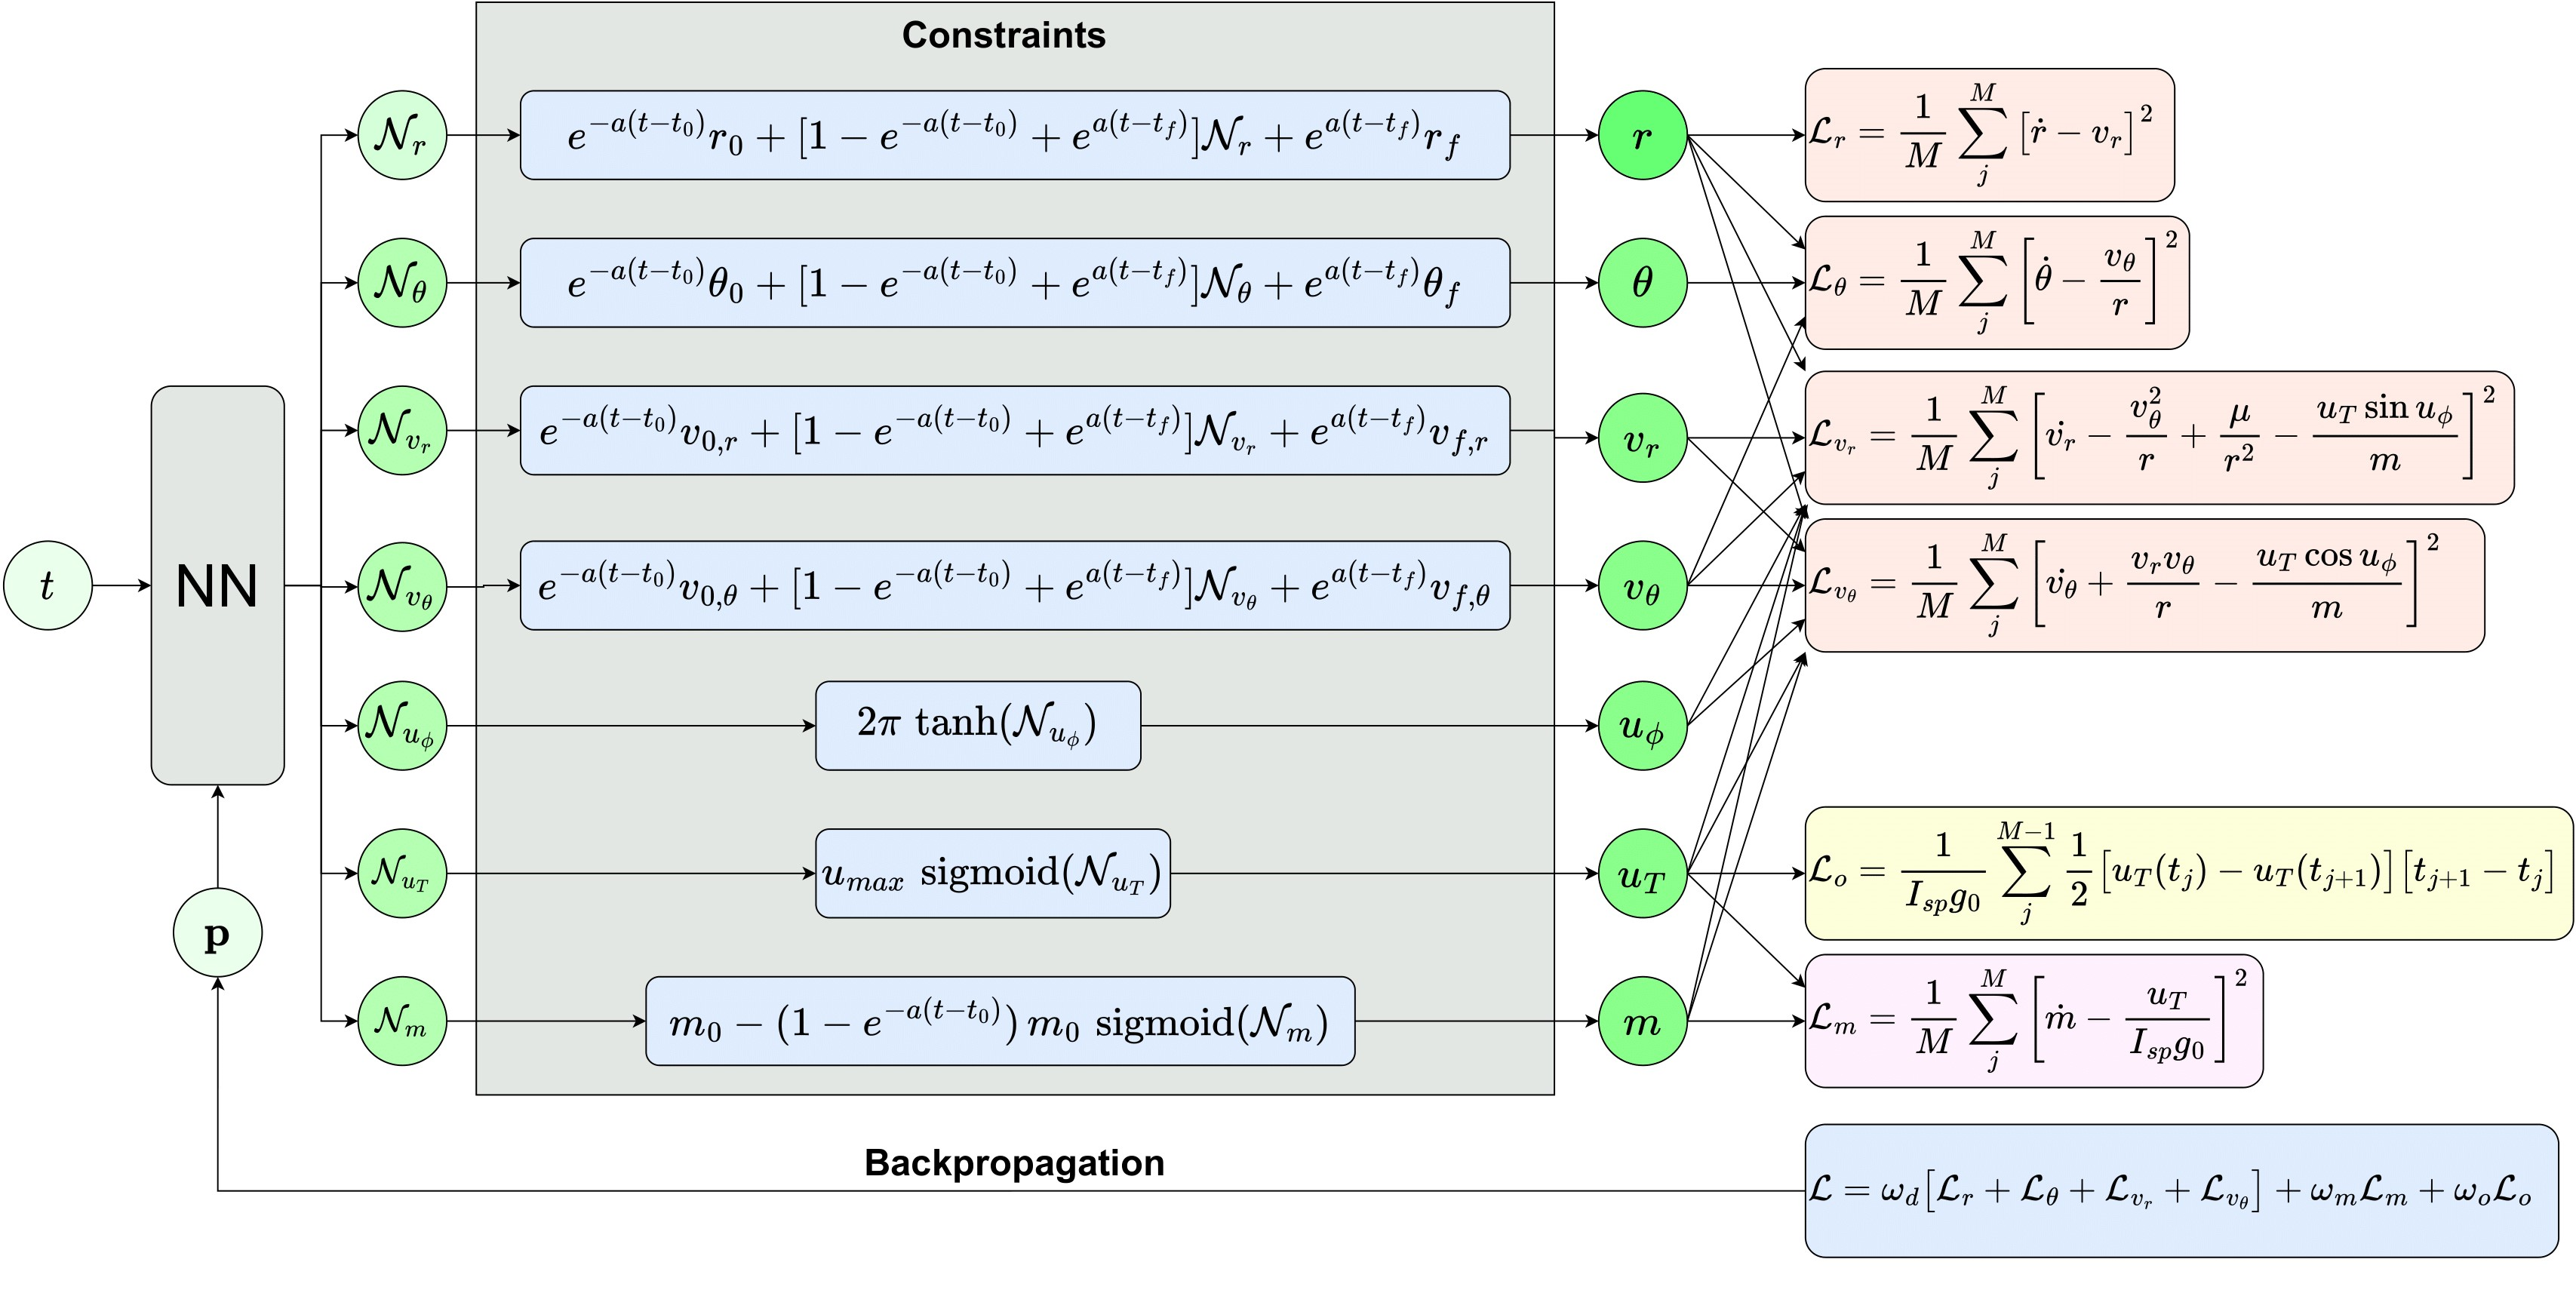

The DOLPHINN package uses 3 user-defined classes that together describe the basic components of the optimal control problem

1. The **<u>dynamics</u>** loss (default options in `DOLPHINN.dynamics`)
2. The **<u>constraint</u>** layer (default options in `DOLPHINN.output_layer`)
3. The **<u>objective</u>** loss (default options in `DOLPHINN.objectives`)

I wil go over these 3 and manually implement the classes for the problem described above. 

# The Dynamics 

The latent neural network solution is made to adhere to the dynamical constraints, the equations of motion, by training the network on a loss that describes the equations of motion. This dynamics loss will be coded into a class. 

- The dynamics loss class has to inherrit the `DOLPHINN.function.Function` class 
- The loss should be calculated in the user-defined (overloaded) `call` method
- The `call` method should have signature `call(self, #network_input, #network_output`)
- The output should be a list of tensors. The index in the list indicates the specific dynamics loss term (e.g. $\dot{r} = v_r$). The tensor has shape $(M, 1)$ where $M$ is the amount of training points in the batch. [WARNING] the output of the `call` function is later used to get the mean squared error, per dynamics loss term. Don't take means or squares inside the dynamics class. 
- The derivatives in the equations of motion can be calculated with automatic differentiation by using the `deepxde.grad` module. 
- Use only `tensorflow` math operations (so no `numpy`), because this will be used by Tensorflow during training.
- You can use `self.parameter` to reach a constants named `parameter`, that might be present in the equations motion. For example $m$, $I_{sp}$ or $u_{max}$.  `DOLPHINN.function.Function` makes sure of this. You can declare their value to the DOLPHINN class later. 
- The class should have the following class attributes 
    - `coordinates` (str): \
    The type of coordinates. The name declared here should be in line with the coordinates transformation functions in `DOLPHINN.coordinate_transformations`. Transformatinos currently exist for `radial` and `NDcartesian`. One should always make sure that the `<coordinate_name>_to_NDcartesian` transformation exists.
    
    - `mass` (bool): \
    This boolean declares wheter or not the mass of the spacecraft is modelled. If set to `True`, DOLPHINN will assume that it's the last output entry from the network.
    
    - `control` (bool): \
    This boolean declares whether or not the spacecraft can be controlled. If set to `True`, DOLPHINN assumes that the final output entries of the network are the control entries, except when a mass is included, that they will be in front of the mass. The order is thus `[state_entries, control_entries, mass_entry]`. 
    - `entries` (int) \
    The amount of control entries plus the amount of state entries. 
     - `entry_labels` (list) \
    List with `entries` amount of strings that are used for printing purposes of the various state and control entries.   
    - `control_entries` (int) \
    The amount of control entries. 
    - `loss_entries` (int) \
    The amount of dynamics loss terms, including the potential mass loss term
    - `loss_labels` (list) \
    List with `loss_entries` amount of strings that are used for printing purposes of the various loss terms. 
    - `theta` (boolean): \
    If using polar coordinates, this declares whether or not the dynamics include theta or not. If using polar coordinates and `theta` is set to `False`, theta will be calculated afterwards from the establisehd $v_{\theta} (t)$ and $r (t)$. An example where this is useful, is if one wants to not constraint theta, for example if one simply want to get to a higher orbit and does not care at what phase angle in that orbit. Always put to `false` if coordinates are not polar. 


In [9]:
import tensorflow as tf
import deepxde as dde
import numpy as np

# Same as "DOLPHINN.dynamics.TwoBodyProblemRadialThetaNonDimensionalControl_mass"
class Dynamics(Function): 
        
    # Class attributes
    coordinates = 'radial'
    mass = True
    control = True
    entries = 6
    entry_labels = ["r", r"$\theta$", "v$_r$ ", r"v$_{\theta}$", "u$_r$", r"u$_{\theta}$"]
    control_entries = 2
    loss_entries = 5
    loss_labels = ["r", "v$_r$", r"v$_{\theta}$", "m"]
    theta = True
   
    def call(self, time, y):

            # Coordinate entries
            x1    = y[:, 0:1] #r
            theta = y[:, 1:2] 
            x2    = y[:, 2:3] #v_r
            x3    = y[:, 3:4] #v_theta

            # Control entries
            ur    = y[:, 4:5]
            ut    = y[:, 5:6]

            # Mass entry
            m     = y[:, 6:7]

            # Thrust magnitude
            T = tf.reshape(tf.norm(y[:, 4:6], axis = 1), (-1, 1))

            # LHS of equations of motion (Automatic differentation)
            dx1_dt    = dde.grad.jacobian(y, time, i=0)
            dtheta_dt = dde.grad.jacobian(y, time, i=1)
            dx2_dt    = dde.grad.jacobian(y, time, i=2)
            dx3_dt    = dde.grad.jacobian(y, time, i=3)
            dm_dt     = dde.grad.jacobian(y, time, i=6)

            # RHS of equations of motion
            RHS_x1     = x2
            RHS_theta  = x3/x1
            RHS_x2     = x3**2/x1 - (self.mu * self.time_scale**2 / self.length_scale**3) * x1**(-2) +\
                          (self.time_scale**2/self.length_scale) * ur / m
            RHS_x3     = - (x2*x3)/x1 + (self.time_scale**2/self.length_scale) * ut / m
            RHS_m      = -T * self.time_scale / (self.isp * 9.81)

            # Return the residuals
            return [
                dx1_dt    - RHS_x1,
                dtheta_dt - RHS_theta,
                dx2_dt    - RHS_x2,
                dx3_dt    - RHS_x3,
                dm_dt     - RHS_m,
                ] 

# The constraints 

The constraints of the problem are included as an additional layer applied to the output layer of the neural network. This layer is coded in an output layer class. 

- The output layer class has to inherrit the `DOLPHINN.function.Function` class 
- The layers behaviour should be calculated in the user-defined (overloaded) `call` method
- The `call` method should have signature `call(self, #network_input, #network_output`)
- Use only `tensorflow` math operations (so no `numpy`), because this will be used by Tensorflow during training.
- You can use `self.parameter` to reach a constant named `parameter`, that might be present in the equations motion. For example $m$, $I_{sp}$ or $u_{max}$.  `DOLPHINN.function.Function` makes sure of this. You can declare their value to the DOLPHINN class later. 

In [10]:
# Same as "DOLPHINN.output_layers.InitialFinalStateLayer_RadialTheta_tanh_mass"
class Constraints(Function):

    def call(self, t, y):

        # Time-dependent equations for 
        f1 = tf.math.exp(-self.a*(t-self.t0))
        f2 = 1 - tf.math.exp(-self.a*(t-self.t0)) - tf.math.exp(self.a*(t - self.tfinal))
        f3 = tf.math.exp(self.a*(t-self.tfinal))
        f_mass = 1 - tf.math.exp(-self.a*(t-self.t0))

        # Apply sigmoid to get in [0, 1], while keeping a non-zero derivative for training
        u_norm = tf.math.sigmoid(y[:,4:5])
        u_angle = tf.math.tanh(y[:,5:6])
        m = tf.math.sigmoid(y[:,6:7])

        # Rescale the U_R and the U_theta to their real values
        u_norm = u_norm * self.umax
        u_angle = u_angle * 2*np.pi
        m =  m * self.m

        # Transform the parameterized control entries to the radial/transverse basis
        ur = u_norm * tf.math.sin(u_angle)
        ut = u_norm * tf.math.cos(u_angle)

        # Construct the output of the network
        output = tf.concat([f1*self.initial_state[0] + f2*y[:,0:1] + f3*self.final_state[0],
                           f1*self.initial_state[1] + f2*y[:,1:2] + f3*self.final_state[1],
                           f1*self.initial_state[2] + f2*y[:,2:3] + f3*self.final_state[2],
                           f1*self.initial_state[3] + f2*y[:,3:4] + f3*self.final_state[3],
                           ur,
                           ut,
                           self.m - f_mass * m], axis = 1
                          )

        return output

# The Objective

The objective of the optimal control problem is included as an additional term to the loss function. The objective function is coded in an objective class. 

- The objective has to inherrit the `DOLPHINN.function.Function` class 
- The layers behaviour should be calculated in the user-defined (overloaded) `call` method
- The `call` method should have signature `call(self, #network_input, #network_output, #losses`)
- Use only `tensorflow` math operations (so no `numpy`), because this will be used by Tensorflow during training.
- You can use `self.parameter` to reach a constants named `parameter`, that might be present in the equations motion. For example $m$, $I_{sp}$ or $u_{max}$.  `DOLPHINN.function.Function` makes sure of this. You can declare their value to the DOLPHINN class later. 
- [Warning] The output of this function is the literal objective loss term. That means that there is no mean squared taken after this function, like for the dynamical class. 

In [12]:
import tensorflow_probability as tfp

# Based on "DOLPHINN.objectives.OptimalFuel". The difference is that OptimalFuel 
# also works if the mass rate is not modelled.
class Objective(Function):

    def call(self, t, y, losses):
        '''
        Calculate consumed mass by integrating the thrust profile.
        Requires a whole batch of input/output pairs and creates 
        a scalar fitness value.
        '''

        # Get control and calculate norm
        t = tf.reshape(t, (1, -1))[0] * self.time_scale
        U = y[:, 4:-1]
        U_norm = tf.norm(U, axis=1)

        # Sort time and control
        idx = tf.argsort(t)
        t_sorted = tf.gather(t, idx)
        U_norm_sorted = tf.gather(U_norm, idx)

        # Intergrate thrust magnitude to get propellent mass
        propellent_mass = (1/self.isp/9.81) * tfp.math.trapz(U_norm_sorted, t_sorted)

        return propellent_mass

# Metrics

In order to asses the networks perfomence, while the network is training, some metrics can be created. 


Generally the following holds for creating a metric: 
- Make a class that inherrits the `DOLPHINN.metrics.Metric` class
- Create a custom `call` method with signature `call(self, train_state)`. The train_state is a `deepxde.model.TrainState` class instance. This contains information about the current state of the network. That is, the test/train loss up till now, the input/output of the newest test evaluation of the network, and the input/output of the best test evaluation of the network. This argument is mandatory as Deepxde expects to receive it.
- The `call` method should return the metric as a scalar value. 
- Metrics are stored during training everytime a test evaluation of the network is performed. 


Special functionality exists in the `DOLPHINN.metrics.Metric` parent class that can perform a verification numerical integration <i>while training</i>. It can be accesed like this: 

- Inside the `call` method, call the `run_verification(train_state)` method.
- The `run_verification(train_state)` method will use TUDAT to do a verification integration of the control profile and initial state inside the `DOLPHINN.verification.Verification` class using the current train_state.
- The `run_verification(train_state)` method returns the neural network states from the test evaluation, the verification states from the numerical integrations, the masses from the neural network test evaluation and the masses from the numerical integration. 
- The `run_verification(train_state)` method is clever and does not do multiple verification runs if multiple metrics require this. 


The resulting verification states can be used to calculate metrics such as $dx$, $dv$ and $dm$. 

In [13]:
from DOLPHINN.metrics import Metric 

class FinalDr(Metric):
    '''
    Final euclidian position difference metric "dx"
    '''
    
    def call(self, train_state):

        # Get the neural network states and verification states 
        states, verification_states, _, _ = self.run_verification(train_state)
        
        # Calculate the euclidian position difference
        return np.linalg.norm(states[-1,1:3] - verification_states[-1,1:3])

class FinalDv(Metric):
    '''
    Final euclidian velocity difference metric
    '''

    def call(self, train_state):

        # Get the verification information
        states, verification_states, _, _ = self.run_verification(train_state)
        return np.linalg.norm(states[-1,3:5] - verification_states[-1,3:5])

class FinalDm(Metric):
    '''
    Final mass difference metric
    '''

    def call(self, train_state):

        # Get the verification information
        _, _, masses, verification_masses = self.run_verification(train_state)
        return masses[-1] - verification_masses[-1]

# The transfer problem

Now that the dynamics, constraints and objective component have been coded, lets declare some problem specific constants and boundary conditions. 

### Constants

In [14]:
mu      = 1.32712440042e20 # SUN
m       = 100              # Spacecraft initial mass
AU      = 1.5e11           # EARTH-SUN
a       = 10               # The steepness parameter in the constraint layer 
umax    = 0.1              # The maximum thrust in N	
isp     = 2500             # The specific impulse in seconds

### Normalisation
It is crucial to normalize position and time for a neural network.
- `DOLPHINN` works with a system where the time and position can be scaled with an abitrary scalar value. 
- The time normalisation is declared in `time_scale` 
- The length normalisation in declared in `length_scale`
- In the Earth-Mars Transfer, it is clever to choose the length scale as 1 AU.
- The time scale will be chosen such that the velocity is scaled to Earth's orbital velocity

In [15]:
length_scale   = AU
time_scale     = length_scale / np.sqrt(mu/AU) 

### Boundary conditions 

- The intial state should be declared as `initial_state`
- The final state should be declared as `final_state`
- The initial time should be declared as `t0`, in the normalised units!
- The final time should be declared as `tfinal`, in the normalised units!


In this case we choose the boundary conditions such that in precisely 1 revolution ($2 \pi$ phase angle) and 400 days, the spacecraft is suppoed to meet Mars and match its velocity. 

In [18]:
# Initial state
r0            = AU                        # Start in Earths orbit
theta0        = 0                         # Arbitrary start angle
vr0           = 0                         # no radial velocity
vt0           = np.sqrt(mu/r0)            # circular velocity
initial_state = np.array([r0, theta0, vr0, vt0])

# Final state
rfinal        = 1.5*AU                    # End in Mars' orbit
theta_final   = 2*np.pi                   # 2 pi phase angle
vr_final      = 0                         # no radial velocity
vt_final     = np.sqrt(mu/rfinal)        # circular velocity
final_state   = np.array([rfinal, theta_final, vr_final, vt_final])

t0            = 0 / time_scale            # In normalised units
tfinal        = 400*24*3600 / time_scale  # In normalised units

# Neural Network Configuration

Finally, some components of the neural network architecture and training have to be declared 

- `N_train` (int): the amount of training points per batch
- `N_test`  (int): the amount of test points
- `sampler` (str): the name of the training batch sampler. This can typically be kept to `perturbed_uniform_tf`. The standard deviation for the perturbation is optionally declared as `sampler_std`. The default value is 0.2*(tfinal - t0)/N_train. 
- `activation` (str): the activation function of all layers except the output layer, which is fixed to a linear activation
- `architecture` (list): List with neurons per layer. First index is the input layer, typically 1 neuron for time. Last index is the output layer, for example 7 for 4 state entries, 2 control entries and a mass entry. Additional indices are hidden layers. If an index for a hidden layer is a list on its own, it describs the neurons in a parallel system of networks. 
     - For example `architecture = [1, [10]*7, [10]*7, 7]` means 7 parallel networks with each 2 hidden layers with 10 neurons per hidden layer. 
     - For example, `architecture = [1, 10, 10, 7]` means a fully connected single neural network with 2 hidden layers with 10 neurons per hidden layer. 

In [24]:
# Network configuration
N_train       = 200
N_test        = 200
activation    = "sin"
architecture  = [1, 20, 20, 20, 20, 20, 7] 
sampler       = "perturbed_uniform_tf"

# Create DOLPHINN!

- First collect all constants, boundary condition, and network configurations into the `data` dictionary

Now, we create a `DOLPHINN.pinn.DOLPHINN` class instance, which is the central object of this module.

- It requires the following arguments:
     - `data` (dict): A dictionary containing all the constants and network choices. The following keys are mandatory: 
         - t0 
         - tfinal
         - activation 
         - architecture
         - N_train
         - N_test
         - N_boundary
         - sampler
     - `dynamics` (DOLPHINN.function.Function subclass): A class implementing the dynamics loss function in an overloaded `call` method.

- The folloinwg arguments are optional 
    - `output_transform` (DOLPHINN.function.Function subclass): A class implementing a layer applied to the network output in an overloaded `call` method.
    - `input_transform` (DOLPHINN.function.Function subclass): A class implementing a layer applied to the input before the NN in an overloaded `call` method. 
    - `objective` (DOLPHINN.function.Function subclass): A class implementing the objective loss term in an overloaded `call` method. 
    - `metrics` (list): Containing metrics, classes that inherrit DOLPHINN.metrics.Metric 
    - `callbacks` (list):  Containing callbacks, classes that inherrit DOLPHINN.callbacks.Callback
    - `seed` (int): A seed to initialize the weights and biases in the network. If not provided, a time-based (%Y%m%d%H%M%S) random seed it used.
    - `display_every` (int): Determines the interval of epochs between test evaluations
    - `verbose` (bool): Printing behaviour before, during and after training.
         


In [25]:
from DOLPHINN.pinn import DOLPHINN
from DOLPHINN.metrics import Fuel # This uses the same calculation as the objective, but performed on the test evaluation run and stored as a metric.

data = {"initial_state": initial_state,
        "final_state": final_state,
        "m": m,
        "mu": mu,
        "a": a,
        "umax": umax,
        "isp": isp,
        "length_scale": length_scale,
        "time_scale": time_scale,
        "t0": t0,
        "tfinal": tfinal,
        "architecture": architecture,
        "activation": activation,
        "N_train": N_train,
        "N_test": N_test,
        "sampler": "perturbed_uniform_tf"}

Transfer = DOLPHINN(data, 
                    Dynamics, 
                    output_transform = Constraints,
                    objective = Objective, 
                    metrics = [FinalDr, FinalDv, FinalDm, Fuel])
                    